In [22]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay


In [23]:
# Load the dataset
df = pd.read_csv('/content/cleaned_new_train_EGN5442.csv')
df = df.drop('Unnamed: 0', axis=1)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104722 entries, 0 to 104721
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y       104722 non-null  int64  
 1   x3      104722 non-null  int64  
 2   x9      104722 non-null  int64  
 3   x10     104722 non-null  int64  
 4   x11     104722 non-null  int64  
 5   x12     104722 non-null  int64  
 6   x13     104722 non-null  int64  
 7   x14     104722 non-null  int64  
 8   x15     104722 non-null  int64  
 9   x16     104722 non-null  int64  
 10  x17     104722 non-null  int64  
 11  x18     104722 non-null  int64  
 12  x19     104722 non-null  int64  
 13  x20     104722 non-null  int64  
 14  x21     104722 non-null  int64  
 15  x22     104722 non-null  int64  
 16  x23     104722 non-null  int64  
 17  x25     104722 non-null  int64  
 18  x26     104722 non-null  int64  
 19  x28     104722 non-null  int64  
 20  x31     104722 non-null  float64
 21  x4      10

,y,x3,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x25,x26,x28,x31,x4,x6
0,1,0,5,5,5,4,3,5,3,3,4,5,5,3,4,3,21,0,0,1,2.380952,4,50
1,1,0,1,1,1,1,3,3,1,4,4,4,4,4,4,2,0,1,0,1,2.230769,4,44
2,0,0,3,1,5,5,3,2,2,3,3,3,3,1,3,2,0,1,0,3,2.230769,4,72
3,0,0,1,3,1,3,5,1,5,5,2,4,4,1,4,5,0,1,1,3,2.230769,4,38
4,1,1,5,5,5,5,2,5,5,4,4,4,4,4,4,5,0,1,0,1,2.230769,4,37


In [24]:
# Splitting data
X = df.drop('y', axis= 1)
y = df['y']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size= 0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (73305, 22)
Validation shape: (15708, 22)
Test shape: (15709, 22)


In [25]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

search = RandomizedSearchCV(rf, params, n_iter= 10, cv=5, scoring= 'roc_auc', random_state= 42, n_jobs= -1)
search.fit(X_train, y_train)
best_rf = search.best_estimator_
print("Best Random Forest parameters:", search.best_params_)



Best Random Forest parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [26]:
from sklearn.metrics import roc_auc_score

# Model Evaluation

# Validation Set
val_probs = best_rf.predict_proba(X_val)[:,1]
val_auc = roc_auc_score(y_val, val_probs)
print("Validation AUC:", val_auc)

Validation AUC: 0.9937647910144654


In [27]:
from sklearn.metrics import classification_report
y_predict = best_rf.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8932
           1       0.97      0.94      0.96      6777

    accuracy                           0.96     15709
   macro avg       0.96      0.96      0.96     15709
weighted avg       0.96      0.96      0.96     15709



In [28]:
# Test Set
test_probs = best_rf.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test, test_probs)
test_acc = accuracy_score(y_test, best_rf.predict(X_test))
test_f1 = f1_score(y_test, best_rf.predict(X_test))

print("Test AUC:", test_auc)
print("Test Accuracy :", test_acc)
print("Test F1 Score: ", test_f1)

Test AUC: 0.9932631352812696
Test Accuracy : 0.9628238589343688
Test F1 Score:  0.9561232156273478


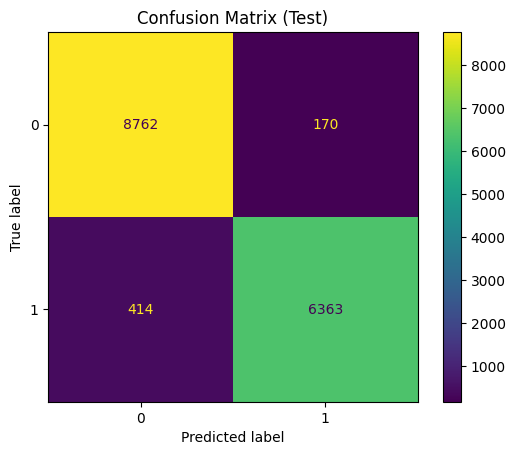

In [29]:
# Confusion matrix on test set
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Confusion Matrix (Test)")
plt.show()

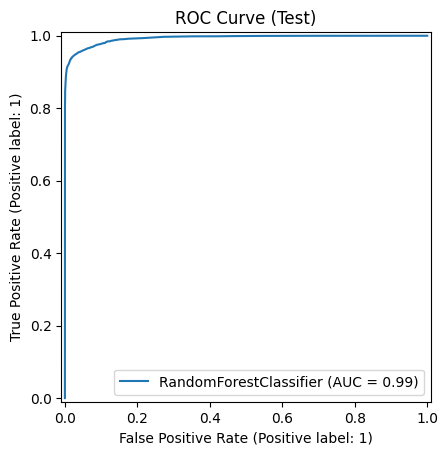

In [30]:
# ROC Curve on test
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC Curve (Test)")
plt.show()

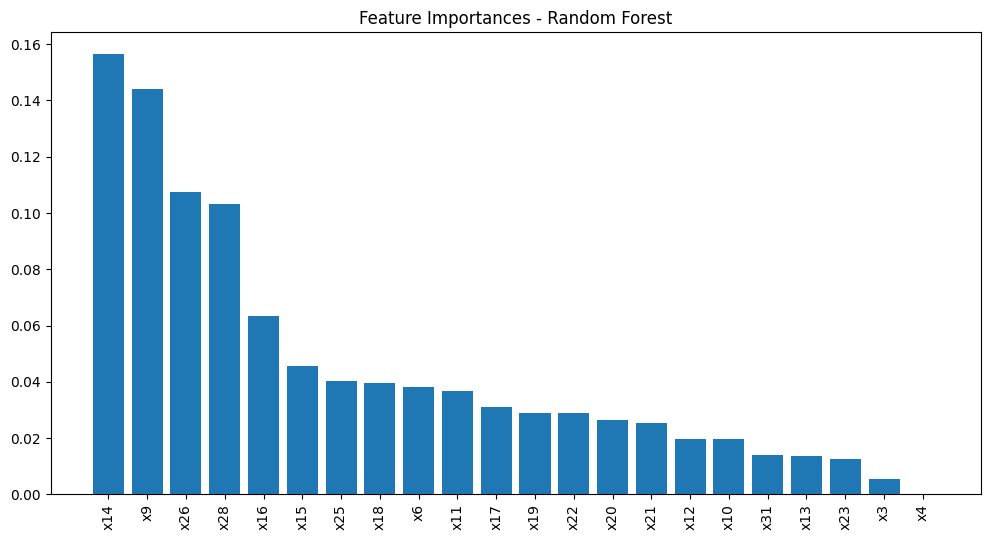

In [31]:
# Feature Importance plot
importances = best_rf.feature_importances_
features= X.columns
inds= np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title('Feature Importances - Random Forest')
plt.bar(range(len(importances)), importances[inds], align= 'center')
plt.xticks(range(len(importances)), features[inds], rotation = 90)
plt.show()